# PyTorch tutorial

Edited by Steve Ive

This document was edited to understand better for beginner of torch and basic concepts of deep learning base on original document below.

https://pytorch.org/tutorials/beginner/nn_tutorial.html

# WHAT IS TORCH.NN REALLY?
by Jeremy Howard, fast.ai. Thanks to Rachel Thomas and Francisco Ingham.

We recommend running this tutorial as a notebook, not a script. To download the notebook (.ipynb) file, click the link at the top of the page.

PyTorch provides the elegantly designed modules and classes torch.nn , torch.optim , Dataset , and DataLoader to help you create and train neural networks. In order to fully utilize their power and customize them for your problem, you need to really understand exactly what they’re doing. To develop this understanding, we will first train basic neural net on the MNIST data set without using any features from these models; we will initially only use the most basic PyTorch tensor functionality. Then, we will incrementally add one feature from torch.nn, torch.optim, Dataset, or DataLoader at a time, showing exactly what each piece does, and how it works to make the code either more concise, or more flexible.

**This tutorial assumes you already have PyTorch installed, and are familiar with the basics of tensor operations.** (If you’re familiar with Numpy array operations, you’ll find the PyTorch tensor operations used here nearly identical).

MNIST data setup
We will use the classic MNIST dataset, which consists of black-and-white images of hand-drawn digits (between 0 and 9).

We will use pathlib for dealing with paths (part of the Python 3 standard library), and will download the dataset using requests. We will only import modules when we use them, so you can see exactly what’s being used at each point.

# MNIST data setup

We will use the classic MNIST dataset, which consists of black-and-white images of hand-drawn digits (between 0 and 9).

We will use pathlib for dealing with paths (part of the Python 3 standard library), and will download the dataset using requests. We will only import modules when we use them, so you can see exactly what’s being used at each point.

In [93]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"

FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

This dataset is in numpy array format, and has been stored using pickle, a python-specific format for serializing data.

In [94]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

Each image is 28 x 28, and is being stored as a flattened row of length 784 (=28x28). Let’s take a look at one; we need to reshape it to 2d first.

(50000, 784)


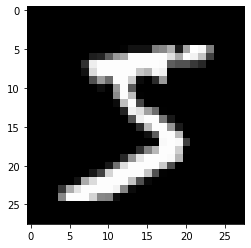

In [95]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

PyTorch uses torch.tensor, rather than numpy arrays, so we need to convert our data.

### Take a Moment!

### Python map() function

```map()``` function returns a map object(which is an iterator) of the results after applying the given function to each item of a given iterable (list, tuple etc.)

**Syntax** :

> ```map(fun, iter)```

**Parameters** :

> fun : It is a function to which map passes each element of given iterable.

> iter : It is a iterable which is to be mapped.

**NOTE** : You can pass one or more iterable to the map() function.

**Returns** :

> Returns a list of the results after applying the given function  
to each item of a given iterable (list, tuple etc.) 
 
**NOTE** : The returned value from map() (map object) then can be passed to functions like list() (to create a list), set() (to create a set) .
 

### Take a Moment! 
### ```torch.tensor()``` function

> ```torch.tensor(data, *, dtype=None, device=None, requires_grad=False, pin_memory=False)``` → Tensor

Constructs a tensor with data.

**Parameters**
> **data (```array_like```)** – Initial data for the tensor. Can be a list, tuple, NumPy ndarray, scalar, and other types.

**Keyword Arguments**
- **dtype (```torch.dtype```, optional)** – the desired data type of returned tensor. Default: ***if None, infers data type from data.***

- **device** (```torch.device```, optional) – the desired device of returned tensor. Default: if None, uses the current device for the default tensor type (see torch.set_default_tensor_type()). device will be the CPU for CPU tensor types and the current CUDA device for CUDA tensor types.

- **requires_grad** (bool, optional) – If autograd should record operations on the returned tensor. Default: False.

- **pin_memory** (bool, optional) – If set, returned tensor would be allocated in the pinned memory. Works only for CPU tensors. Default: False.

---

### TORCH.TENSOR datatype
A ```torch.Tensor``` is a multi-dimensional matrix containing elements of a single **data type**.

In [96]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(x_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0.) tensor(9)


# Neural net from scratch (no torch.nn)
Let’s first create a model using nothing but PyTorch tensor operations. We’re assuming you’re already familiar with the basics of neural networks. (If you’re not, you can learn them at course.fast.ai).

PyTorch provides methods to create random or zero-filled tensors, which we will use to create our weights and bias for a simple linear model. These are just regular tensors, with one very special addition: we tell PyTorch that they require a gradient. This causes PyTorch to record all of the operations done on the tensor, so that it can calculate the gradient during back-propagation automatically!

For the weights, we set requires_grad **after** the initialization, since we don’t want that step included in the gradient. (Note that a trailing _ in PyTorch signifies that the operation is performed in-place.)

**NOTE**

We are initializing the weights here with Xavier initialisation (by multiplying with 1/sqrt(n)).


### Take a Moment!
### TORCH.TENSOR.REQUIRES_GRAD_

```Tensor.requires_grad_```(requires_grad=True) → Tensor

Change if autograd should record operations on this tensor: sets this tensor’s requires_grad attribute in-place. Returns this tensor.

requires_grad_()’s main use case is to tell autograd to begin recording operations on a Tensor tensor. If tensor has requires_grad=False (because it was obtained through a DataLoader, or required preprocessing or initialization), tensor.requires_grad_() makes it so that autograd will begin to record operations on tensor.

Parameters
**requires_grad** (bool) – If autograd should record operations on this tensor. Default: True.

Example:

> ```>>> # Let's say we want to preprocess some saved weights and use
>>> # the result as new weights.
>>> saved_weights = [0.1, 0.2, 0.3, 0.25]
>>> loaded_weights = torch.tensor(saved_weights)
>>> weights = preprocess(loaded_weights)  # some function
>>> weights
tensor([-0.5503,  0.4926, -2.1158, -0.8303])```

> ```>>> # Now, start to record operations done to weights
>>> weights.requires_grad_()
>>> out = weights.pow(2).sum()
>>> out.backward()
>>> weights.grad
tensor([-1.1007,  0.9853, -4.2316, -1.6606])```

In [97]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

Thanks to PyTorch’s ability to calculate gradients automatically, we can use any standard Python function (or callable object) as a model! So let’s just write a plain matrix multiplication and broadcasted addition to create a simple linear model. We also need an activation function, so we’ll write log_softmax and use it. Remember: although PyTorch provides lots of pre-written loss functions, activation functions, and so forth, you can easily write your own using plain python. PyTorch will even create fast GPU or vectorized CPU code for your function automatically.

In [98]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In the above, the @ stands for the dot product operation. We will call our function on one batch of data (in this case, 64 images). This is one forward pass. Note that our predictions won’t be any better than random at this stage, since we start with random weights.

In [99]:
bs = 64

xb = x_train[0:bs]
preds = model(xb)
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.6983, -1.9944, -2.6378, -2.7262, -2.1044, -2.3184, -2.5540, -1.6090,
        -2.4584, -2.5794], grad_fn=<SelectBackward>) torch.Size([64, 10])


As you see, the preds tensor contains not only the tensor values, but also a gradient function. We’ll use this later to do backprop.

Let’s implement negative log-likelihood to use as the loss function (again, we can just use standard Python):

### Take a Moment!

```preds[range(target.shape[0]), target]```

This is an indices itself to index of an specific matrix or a vector.

so, if ```np.array([range(target.shape[0]), target])``` or just as a list like ```[range(target.shape[0]), target]``` will only show the itself, as

```
[range(0, 64), tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0])]```



In [100]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

Let’s check our loss with our random model, so we can see if we improve after a backprop pass later.

In [101]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3704, grad_fn=<NegBackward>)


Let’s also implement a function to calculate the accuracy of our model. For each prediction, if the index with the largest value matches the target value, then the prediction was correct.

In [102]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

Let’s check the accuracy of our random model, so we can see if our accuracy improves as our loss improves.



In [103]:
print(accuracy(preds, yb))

tensor(0.0938)


We can now run a training loop. For each iteration, we will:

select a mini-batch of data (of size bs)
use the model to make predictions
calculate the loss
loss.backward() updates the gradients of the model, in this case, weights and bias.
We now use these gradients to update the weights and bias. We do this within the torch.no_grad() context manager, **because we do not want these actions to be recorded for our next calculation of the gradient.** You can read more about how PyTorch’s Autograd records operations here. https://pytorch.org/docs/stable/notes/autograd.html

We then set the gradients to zero, so that we are ready for the next loop. Otherwise, our gradients would record a running tally of all the operations that had happened (i.e. loss.backward() adds the gradients to whatever is already stored, rather than replacing them).

**TIP**

You can use the standard python debugger to step through PyTorch code, allowing you to check the various variable values at each step. Uncomment set_trace() below to try it out.

In [104]:
from IPython.core.debugger import set_trace

lr=0.5
epochs = 2

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        # set_trace()
        start_i = i *bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        loss.backward() ## take backward() since loss return the torch.Tensor

        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()


### Take a Moment!

### NO_GRAD
CLASS ```torch.no_grad```
Context-manager that disabled gradient calculation.

Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward(). It will reduce memory consumption for computations that would otherwise have requires_grad=True.

In this mode, the result of every computation will have requires_grad=False, even when the inputs have requires_grad=True.

This context manager is thread local; it will not affect computation in other threads.

Also functions as a decorator. (Make sure to instantiate with parenthesis.)


### TORCH.TENSOR.BACKWARD

```Tensor.backward(gradient=None, retain_graph=None, create_graph=False, inputs=None)```
Computes the gradient of current tensor w.r.t. graph leaves.

The graph is differentiated using the chain rule. If the tensor is non-scalar (i.e. its data has more than one element) and requires gradient, the function additionally requires specifying gradient. It should be a tensor of matching type and location, that contains the gradient of the differentiated function w.r.t. self.

This function accumulates gradients in the leaves - you might need to zero .grad attributes or set them to None before calling it. See Default gradient layouts for details on the memory layout of accumulated gradients.

**NOTE**

If you run any forward ops, create gradient, and/or call backward in a user-specified CUDA stream context, see Stream semantics of backward passes.

#### Parameters
- **gradient** (Tensor or None) – Gradient w.r.t. the tensor. If it is a tensor, it will be automatically converted to a Tensor that does not require grad unless create_graph is True. None values can be specified for scalar Tensors or ones that don’t require grad. If a None value would be acceptable then this argument is optional.

- **retain_graph** (bool, optional) – If False, the graph used to compute the grads will be freed. Note that in nearly all cases setting this option to True is not needed and often can be worked around in a much more efficient way. Defaults to the value of create_graph.

- **create_graph** (bool, optional) – If True, graph of the derivative will be constructed, allowing to compute higher order derivative products. Defaults to False.

- **inputs** (sequence of Tensor) – Inputs w.r.t. which the gradient will be accumulated into .grad. All other Tensors will be ignored. If not provided, the gradient is accumulated into all the leaf Tensors that were used to compute the attr::tensors. All the provided inputs must be leaf Tensors.

That’s it: we’ve created and trained a minimal neural network (in this case, a logistic regression, since we have no hidden layers) entirely from scratch!

Let’s check the loss and accuracy and compare those to what we got earlier. We expect that the loss will have decreased and accuracy to have increased, and they have.

### Take a Moment!

Why this is logit regression?

--- add



In [105]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0796, grad_fn=<NegBackward>) tensor(1.)


## Using torch.nn.functional
We will now refactor our code, so that it does the same thing as before, only we’ll start taking advantage of PyTorch’s nn classes to make it more concise and flexible. At each step from here, we should be making our code one or more of: shorter, more understandable, and/or more flexible.

The first and easiest step is to make our code shorter by replacing our hand-written activation and loss functions with those from torch.nn.functional (which is generally imported into the namespace F by convention). This module contains all the functions in the torch.nn library (whereas other parts of the library contain classes). As well as a wide range of loss and activation functions, you’ll also find here some convenient functions for creating neural nets, such as pooling functions. (There are also functions for doing convolutions, linear layers, etc, but as we’ll see, these are usually better handled using other parts of the library.)

If you’re using negative log likelihood loss and log softmax activation, then Pytorch provides **a single function F.cross_entropy that combines the two. So we can even remove the activation function from our model.**

In [108]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

Note that we no longer call ```log_softmax``` in the ```model``` function. Let's confirm that our loss and accuracy are the same as before:

### Take a Moment!

Before, we defined the **model** that the form of dot producted result in the log_softmax,
and give it to the loss function that is the negative likelihood with the yb.

However the ```cross_entropy``` above contains the log_softmax in it, as we can just define the model as ```xb @ weights + bias```.

In [109]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0796, grad_fn=<NllLossBackward>) tensor(1.)


## Refactor using nn.Module

Next up, we’ll use nn.Module and nn.Parameter, for a clearer and more concise training loop. We subclass nn.Module (which itself is a class and able to keep track of state). In this case, we want to create a class that holds our weights, bias, and method for the forward step. nn.Module has a number of attributes and methods (such as .parameters() and .zero_grad()) which we will be using.

**NOTE**

nn.Module (uppercase M) is a PyTorch specific concept, and is a class we’ll be using a lot. nn.Module is not to be confused with the Python concept of a (lowercase m) module, which is a file of Python code that can be imported.


In [112]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

Since we're now using an object instead of just using a function, we first have to instantiate our model:

In [113]:
model = Mnist_Logistic()

Now we can calculate the loss in the same way as before. Note that ```nn.Module``` objects are used as if they are functions (i.e they are ***callable***), but behind the scenes Pytorch will call our ```forward``` method automatically.

In [114]:
print(loss_func(model(xb), yb))

tensor(2.4102, grad_fn=<NllLossBackward>)


Previously for our training loop we had to update the values for each parameter by name, and manually zero out the grads for each parameter separately, like this:

In [115]:
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()

Now we can take advantage of model.parameters() and model.zero_grad() (which are both defined by PyTorch for nn.Module) to make those steps more concise and less prone to the error of forgetting some of our parameters, particularly if we had a more complicated model:

In [ ]:
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()

We’ll wrap our little training loop in a fit function so we can run it again later.

In [116]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i: end_i]
            yb = y_train[start_i: end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

Let’s double-check that our loss has gone down:



In [117]:
print(loss_func(model(xb), yb))


tensor(0.0822, grad_fn=<NllLossBackward>)


## Refactor using nn.Linear

We continue to refactor our code. Instead of manually defining and initializing self.weights and self.bias, and calculating xb  @ self.weights + self.bias, we will instead use the Pytorch class nn.Linear for a linear layer, which does all that for us. Pytorch has many types of predefined layers that can greatly simplify our code, and often makes it faster too.

In [118]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

We instantiate our model and calculate the loss in the same way as before:



In [ ]:
model = Mnist_Logistic()